In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import tensorflow as tf
import keras

import numpy as np
import json
import os
import pickle

# **Sampling layer**

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# **Encoder**

In [ ]:
'''latent_dim = 20

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()'''

'latent_dim = 20\n\nencoder_inputs = keras.Input(shape=(28, 28, 1))\nx = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)\nx = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Flatten()(x)\nx = layers.Dense(16, activation="relu")(x)\nz_mean = layers.Dense(latent_dim, name="z_mean")(x)\nz_log_var = layers.Dense(latent_dim, name="z_log_var")(x)\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")\nencoder.summary()'

In [ ]:
encoder_conv_filters = [32,64,64, 64] 
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [2,2,2,2]
z_dim  = 200
encoder_summary = False
decoder_summary = False
decoder_conv_t_filters = [64,64,32,3]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [2,2,2,2]
use_batch_norm = True
use_dropout = True
input_dim = (128,128,3)
latent_dim = 100

In [ ]:
encoder_input = Input(shape=input_dim, name='encoder_input')

x = encoder_input

n_layers_encoder = len(encoder_conv_filters)

for i in range(n_layers_encoder):
  conv_layer = Conv2D(
                filters = encoder_conv_filters[i]
                , kernel_size = encoder_conv_kernel_size[i]
                , strides = encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

  x = conv_layer(x)

  if use_batch_norm:
    x = BatchNormalization()(x)

  x = LeakyReLU()(x)

  if use_dropout:
    x = Dropout(rate = 0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['encoder_conv_0[0][0]']         
 alization)                                                                                       
                                                                                            

# **Decoder**

In [ ]:
'''latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()'''

'latent_inputs = keras.Input(shape=(latent_dim,))\nx = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)\nx = layers.Reshape((7, 7, 64))(x)\nx = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)\nx = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)\ndecoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)\ndecoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")\ndecoder.summary()'

In [ ]:
decoder_input = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
  
n_layers_decoder = len(decoder_conv_t_filters)

for i in range(n_layers_decoder):
  conv_t_layer = Conv2DTranspose(
                filters = decoder_conv_t_filters[i]
                , kernel_size = decoder_conv_t_kernel_size[i]
                , strides = decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )
  x = conv_t_layer(x)

  if i < n_layers_decoder - 1:
    if use_batch_norm:
      x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_dropout:
      x = Dropout(rate = 0.25)(x)
  else:
    x = Activation('sigmoid')(x)

            

decoder_output = x

decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0     

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# **Preparing the data**

In [ ]:
import cv2
import glob

H = 128
W = 128

def process_data(data_path):
  images = [name for name in glob.glob(data_path+'/Images/*.jpg')]
  images = sorted(images)
  return images

def load_data(path):
  x = process_data(path)
  train_x = []
  for i in range(len(x)):
    train_x.append(read_img(x[i]))
    print(i)
  '''if i >= 1000:
    break'''
  train_x = np.array(train_x)
  return train_x


def read_img(x):
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  x = cv2.resize(x, (W, H))
  x = x / 255.0
  x = x.astype(np.float32)
  return x

In [ ]:
path = "drive/MyDrive/Celebrity Faces Dataset"
train_x = load_data(path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# **Training**

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
print(train_x.shape)
vae.fit(train_x, epochs=200, batch_size=30)

(1865, 128, 128, 3)
Epoch 1/200
63/63 [==============================] - 27s 411ms/step - loss: 10945.5605 - reconstruction_loss: 10391.3809 - kl_loss: 44.3243
Epoch 2/200
63/63 [==============================] - 26s 410ms/step - loss: 9377.4269 - reconstruction_loss: 9199.9141 - kl_loss: 91.6677
Epoch 3/200
63/63 [==============================] - 26s 408ms/step - loss: 9138.0241 - reconstruction_loss: 8943.9043 - kl_loss: 111.1254
Epoch 4/200
63/63 [==============================] - 26s 406ms/step - loss: 8923.1554 - reconstruction_loss: 8813.5479 - kl_loss: 122.0626
Epoch 5/200
63/63 [==============================] - 25s 403ms/step - loss: 8857.3606 - reconstruction_loss: 8713.4453 - kl_loss: 129.8287
Epoch 6/200
63/63 [==============================] - 25s 403ms/step - loss: 8762.9858 - reconstruction_loss: 8637.2705 - kl_loss: 136.4193
Epoch 7/200
63/63 [==============================] - 25s 403ms/step - loss: 8719.8865 - reconstruction_loss: 8541.7139 - kl_loss: 142.8800
Epoch 8

In [ ]:
a = np.random.rand(1,latent_dim)
print(a)

[[0.96070133 0.66528746 0.5135825  0.89262316 0.46448771 0.13243742
  0.12429124 0.29958178 0.32853705 0.94475939 0.41931015 0.24883059
  0.02623982 0.67782701 0.8472035  0.05132282 0.62138234 0.42181126
  0.62300672 0.36959758 0.57424667 0.79585779 0.58547639 0.68178086
  0.32384986 0.8271114  0.29566455 0.37398571 0.35747247 0.82085966
  0.277919   0.40908417 0.10605784 0.42103755 0.42062588 0.45196286
  0.37769894 0.48017857 0.13259821 0.78176873 0.5595764  0.53392568
  0.42503911 0.85945966 0.01577871 0.07941271 0.80418217 0.89144997
  0.68755587 0.63007959 0.9020879  0.21432278 0.1396782  0.70602025
  0.53665418 0.30417014 0.18106507 0.03297539 0.13816998 0.67126738
  0.49965518 0.37641443 0.56797797 0.34591724 0.44881227 0.35558317
  0.87041663 0.31738524 0.758674   0.01926864 0.47637205 0.37012401
  0.48772336 0.49243966 0.90223353 0.31361714 0.74181126 0.40417646
  0.59062426 0.78419323 0.5932267  0.35546331 0.70527313 0.9310105
  0.08309477 0.81277964 0.84254702 0.95326314 0.7

1/1 [==============================] - 0s 24ms/step


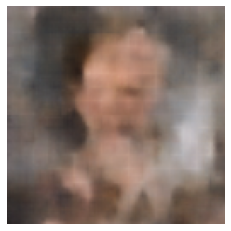

In [ ]:
from matplotlib import pyplot as plt

x_decoded = vae.decoder.predict(a)
#plt.imshow(np.squeeze(img[2]), cmap = 'gray')
plt.imshow(np.squeeze(x_decoded))
plt.axis("off")
plt.show()

In [ ]:
vae.save_weights('vae1')